In [25]:
import sys
import os
import shutil
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
from contextlib import closing
import urllib.request as request
import numpy as np
import ahocorasick
from Bio import SeqIO

In [40]:
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
triqler_file_name = 'out_triqler.tsv'
mzTab_file_name = 'out.mzTab'
output_file = 'identified_peptides.tsv'
contaminants = 'contaminants.fasta'
canonical_proteins_fasta = 'UniProtr11Dec2019+Ensembl103+GENCODE33+RefSeq29May2020.proteins.fasta'
peps_id_dir = 'peptide_ids'
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftplib.FTP.maxline = 100000
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 49


In [42]:
#extract peptides from triqler csv files

#get all peptides from the finished samples
triqler_peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    lines = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, triqler_file_name), lines.append)
        this_peps_df = pd.DataFrame(data=[x.split('\t') for x in lines[1::]],
                          columns = lines[0].split('\t'))
        this_peps_df['Sample'] = sample
        print('Sample {}, #Peptides: {}'.format(sample, len(this_peps_df)))
    except ftplib.error_perm as e: #the search is not done yet!
        print('Sample: {}, error: {}'.format(sample, e))
        continue #to next sample
        
    triqler_peps_df = pd.concat([triqler_peps_df, this_peps_df])
    

Sample PXD003209-Sample-1, #Peptides: 5113
Sample PXD005698-Sample-1, #Peptides: 434
Sample PXD005698-Sample-2, #Peptides: 512
Sample: PXD005698-Sample-4, error: 550 Failed to open file.
Sample PXD005698-Sample-5, #Peptides: 440
Sample PXD005940-Sample-1, #Peptides: 17831
Sample PXD005942-Sample-1, #Peptides: 535
Sample PXD005942-Sample-12, #Peptides: 511
Sample PXD005942-Sample-14, #Peptides: 411
Sample PXD005942-Sample-15, #Peptides: 512
Sample PXD005942-Sample-17, #Peptides: 483
Sample PXD005942-Sample-18, #Peptides: 601
Sample PXD005942-Sample-19, #Peptides: 676
Sample PXD005942-Sample-20, #Peptides: 682
Sample PXD005942-Sample-21, #Peptides: 656
Sample PXD005942-Sample-22, #Peptides: 716
Sample PXD005942-Sample-23, #Peptides: 522
Sample PXD005946-Sample-1, #Peptides: 10379
Sample PXD005946-Sample-10, #Peptides: 7638
Sample PXD005946-Sample-11, #Peptides: 6373
Sample PXD005946-Sample-12, #Peptides: 11209
Sample PXD005946-Sample-13, #Peptides: 9341
Sample PXD005946-Sample-15, #Pepti

In [34]:
#Download mzTab files to a local directory to minimize running time in later runs

#create id output directory if it does not exist
if not os.path.isdir(peps_id_dir):
    os.makedirs(peps_id_dir)
download_files = []
for sample in samples_list:
    try:
        ftp.cwd(sample+'/'+id_dir)
    except ftplib.error_perm as e: #the search is not done yet!
        print('No file is found for sample {}, error:{}'.format(sample, e))
        continue #to next sample
    
    file_url = 'http://{}/{}/{}/{}/{}'.format(ftp_url, samples_dir, sample, id_dir, mzTab_file_name)
    outfile = '{}/{}_{}'.format(peps_id_dir, sample, mzTab_file_name)
    if not os.path.isfile(outfile):
        print('Downloading:', file_url)
        with closing(request.urlopen(file_url)) as r:
            with open(outfile, 'wb') as f:
                shutil.copyfileobj(r, f)
        ftp.sendcmd('PASV')#just to avoid server timeout
    else:
        print('Already exists: ', outfile)
    download_files.append(outfile)
    ftp.cwd('../..')

Already exists:  peptide_ids/PXD003209-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005698-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005698-Sample-2_out.mzTab
No file is found for sample PXD005698-Sample-4, error:550 Failed to change directory.
Already exists:  peptide_ids/PXD005698-Sample-5_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-12_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-14_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-15_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-17_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-18_out.mzTab


In [35]:
#Extract peptides from mzTab files
from pyteomics import mztab

#get all peptides from the finished samples
mztab_psms_df = pd.DataFrame()
mztab_peps_df = pd.DataFrame()
for mzTab_file in glob(peps_id_dir+'/*.mzTab'):
    sample = mzTab_file.split('/')[-1].split('_')[0]
    tables = mztab.MzTab(mzTab_file)#give the mzTab file content
    psms = tables.spectrum_match_table
    peps = tables.peptide_table
    psms['Sample'] = sample
    peps['Sample'] = sample
    print('Sample {}, #PSMS: {}, #Peptides: {}'.format(sample, len(psms), len(peps)))
    mztab_psms_df = pd.concat([mztab_psms_df, psms])
    mztab_peps_df = pd.concat([mztab_peps_df, peps])

Sample PXD005942-Sample-17, #PSMS: 9016, #Peptides: 1822
Sample PXD005946-Sample-11, #PSMS: 86133, #Peptides: 21763
Sample PXD005942-Sample-22, #PSMS: 7815, #Peptides: 3151
Sample PXD005942-Sample-1, #PSMS: 5761, #Peptides: 2377
Sample PXD005698-Sample-2, #PSMS: 732, #Peptides: 646
Sample PXD005946-Sample-10, #PSMS: 88300, #Peptides: 24877
Sample PXD005942-Sample-23, #PSMS: 5129, #Peptides: 2072
Sample PXD005698-Sample-5, #PSMS: 627, #Peptides: 539
Sample PXD003209-Sample-1, #PSMS: 18722, #Peptides: 6679
Sample PXD005942-Sample-20, #PSMS: 9199, #Peptides: 3648
Sample PXD005942-Sample-15, #PSMS: 8129, #Peptides: 1867
Sample PXD005942-Sample-18, #PSMS: 7556, #Peptides: 3003
Sample PXD005946-Sample-1, #PSMS: 103623, #Peptides: 44714
Sample PXD005940-Sample-1, #PSMS: 162992, #Peptides: 116859
Sample PXD005942-Sample-21, #PSMS: 8421, #Peptides: 3450
Sample PXD005942-Sample-14, #PSMS: 6471, #Peptides: 1384
Sample PXD005942-Sample-19, #PSMS: 7842, #Peptides: 3203
Sample PXD005942-Sample-12, #

In [65]:
mztab_psms_df.columns

Index(['sequence', 'PSM_ID', 'accession', 'unique', 'database',
       'database_version', 'search_engine', 'search_engine_score[1]',
       'modifications', 'retention_time', 'charge', 'exp_mass_to_charge',
       'calc_mass_to_charge', 'spectra_ref', 'pre', 'post', 'start', 'end',
       'opt_global_FFId_category', 'opt_global_feature_id',
       'opt_global_map_index', 'opt_global_spectrum_reference',
       'opt_global_cv_MS:1000889_peptidoform_sequence',
       'opt_global_Posterior_Error_Probability_score', 'opt_global_q-value',
       'opt_global_cv_MS:1002217_decoy_peptide', 'Sample'],
      dtype='object')

In [47]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(triqler_peps_df), len(set(triqler_peps_df['Sample'])), len(triqler_peps_df)/len(set(triqler_peps_df.Sample))))
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(mztab_peps_df), len(set(mztab_peps_df['Sample'])), len(mztab_peps_df)/len(set(mztab_peps_df.Sample))))
print('\nExtracted {} PSMs from {} Samples, Avg. PSMs per Sample: {}\n'.format(len(mztab_psms_df), len(set(mztab_psms_df['Sample'])), len(mztab_psms_df)/len(set(mztab_psms_df.Sample))))


Extracted 287212 peptides from 47 Samples, Avg. Peptides per Sample: 6110.893617021276


Extracted 244862 peptides from 19 Samples, Avg. Peptides per Sample: 12887.473684210527


Extracted 545933 PSMs from 19 Samples, Avg. PSMs per Sample: 28733.315789473683



/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='searchScore', ylabel='Density'>

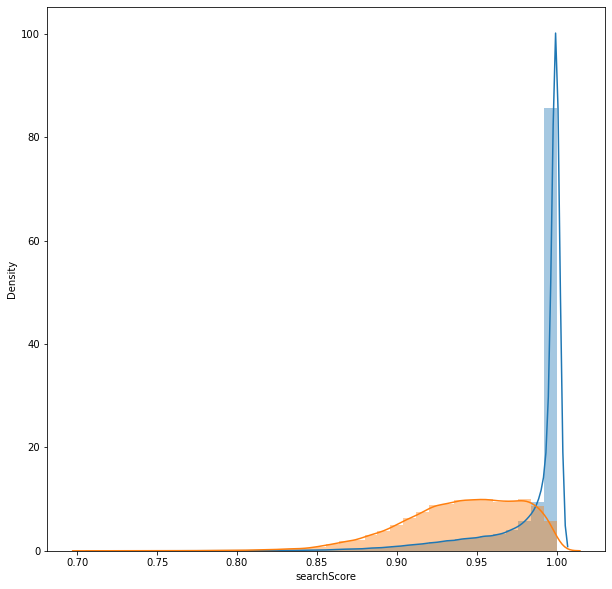

In [48]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

triqler_targets = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == False]
triqler_decoys = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(triqler_targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(triqler_decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

<AxesSubplot:ylabel='Sample'>

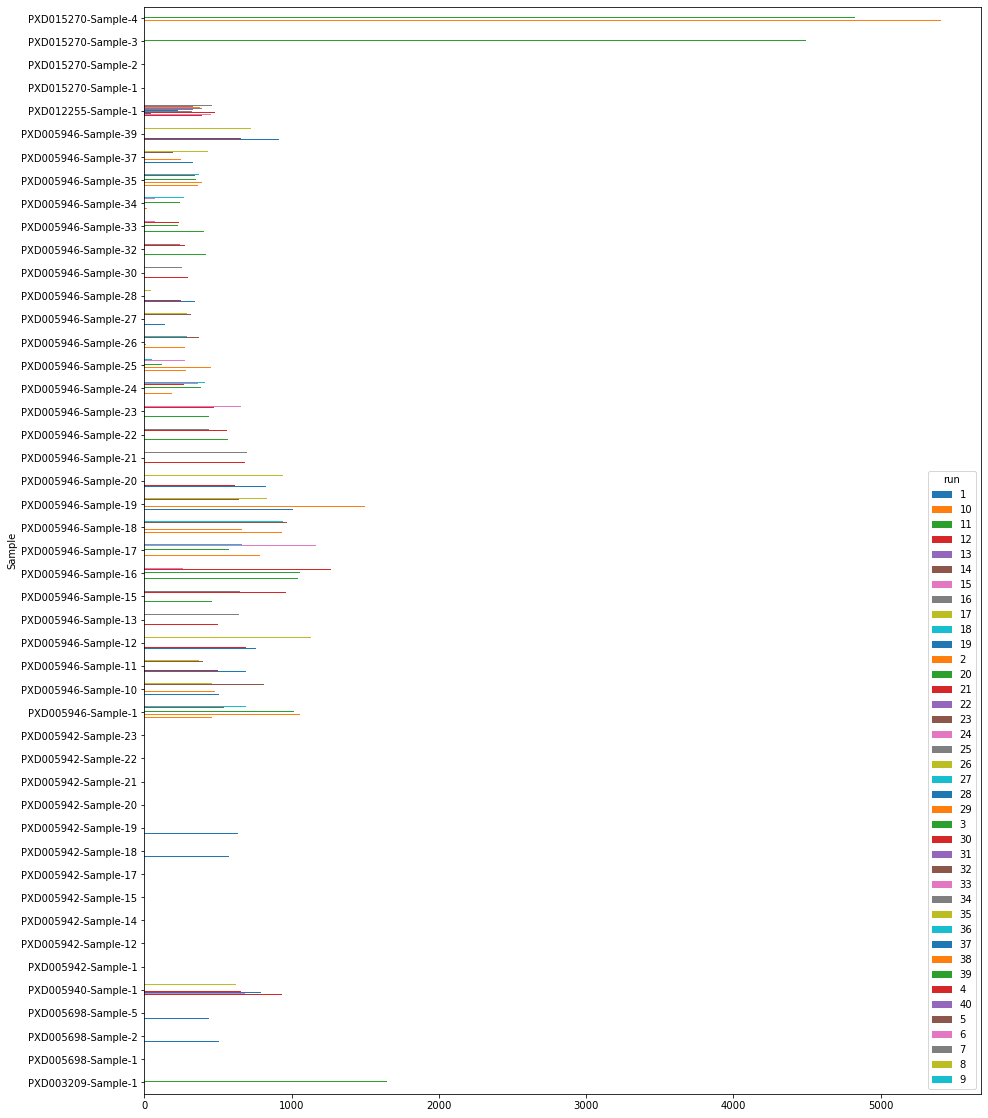

In [49]:
# Print the number of peptides per Sample and ms-run. 

plt.rcParams["figure.figsize"] = [15, 20]
triqler_targets.groupby('run').Sample.value_counts().unstack(0).plot.barh()

In [50]:
#manually wrote uniprot IDs from the contaminate db to a txt file, load to a list to filter out
conatm_ids = '|'.join([x.strip('>').split(' ')[0] for x in open(contaminants, 'r').readlines() if x.startswith('>')])

In [51]:
conditions = [(triqler_targets['proteins'].str.contains("ENSP") & ~triqler_targets['proteins'].str.contains(conatm_ids)),
        (~(triqler_targets['proteins'].str.contains("ENSP")|triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"altorf_|pseudo_|ncRNA_")),
        (~(triqler_targets['proteins'].str.contains(r"ENSP|altorf_|pseudo_|ncRNA_") | triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"COSMIC|cbio")),
        (triqler_targets['proteins'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
triqler_targets['Class'] = np.select(conditions, classes)
triqler_targets['Class'].value_counts()

/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


canonical        221682
non_canonical     23949
contaminant       14923
variant             168
Name: Class, dtype: int64

<AxesSubplot:xlabel='Sample'>

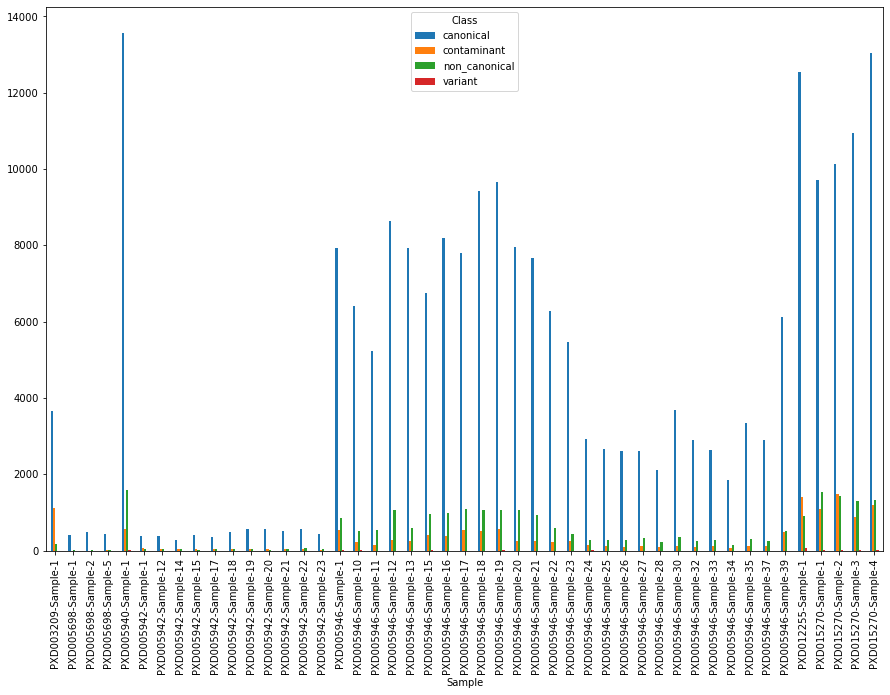

In [52]:
plt.rcParams["figure.figsize"] = [15, 10]
triqler_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [53]:
len(triqler_targets)

260722

In [54]:
triqler_targets.to_csv(output_file, sep='\t', index=False)

In [55]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [56]:
noncan_targets = triqler_targets[triqler_targets['Class'].str.contains(r"variant|non_canonical")==True]
noncan_seqs = list(set([rep(x) for x in noncan_targets['peptide'].tolist()]))

In [57]:
#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

In [58]:
#get non-canonical peptides that are found in canonical proteins
found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        found_peps.append(found)

In [59]:
noncan_targets = noncan_targets[noncan_targets['peptide'].apply(rep).isin(found_peps)==False]

<AxesSubplot:xlabel='Sample'>

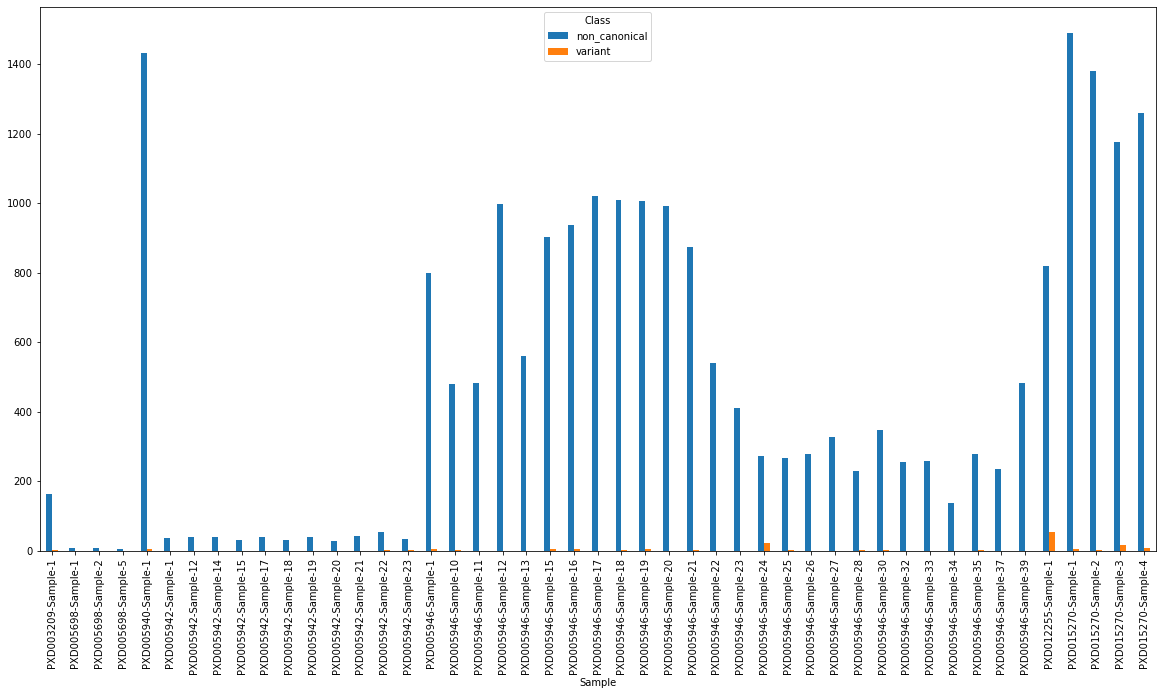

In [60]:
plt.rcParams["figure.figsize"] = [20, 10]
noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [61]:
#close ftp connection
ftp.close()